# eda

In [57]:
import polars as pl
from pathlib import Path
from plotnine import ggplot, aes, geom_histogram, labs, theme_minimal, geom_bar
import pyarrow as pa

In [11]:
data_path = Path('data')
train = pl.read_csv(data_path / 'train_values.csv')
labels = pl.read_csv(data_path / 'train_labels.csv')

In [58]:
(labels.select(pl.exclude("sequence_id").sum())
    .melt(variable_name="lab", value_name="value")
    .pipe(lambda df: ggplot(df, aes(x="value", fill="lab")) +
          geom_bar()
    )
)


/var/folders/8v/x8y04ch95qnb55sh9sh78mmh0000gn/T/ipykernel_6537/3161371844.py:2: DeprecationWarning: `DataFrame.melt` is deprecated; use `DataFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`


ModuleNotFoundError: pa.Table requires 'pyarrow' module to be installed

In [12]:
print(train)

shape: (63_017, 41)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ sequence_ ┆ sequence  ┆ bacterial ┆ bacterial ┆ … ┆ species_o ┆ species_r ┆ species_s ┆ species_ │
│ id        ┆ ---       ┆ _resistan ┆ _resistan ┆   ┆ ther      ┆ at        ┆ ynthetic  ┆ zebrafis │
│ ---       ┆ str       ┆ ce_ampici ┆ ce_chlora ┆   ┆ ---       ┆ ---       ┆ ---       ┆ h        │
│ str       ┆           ┆ lli…      ┆ mph…      ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│           ┆           ┆ ---       ┆ ---       ┆   ┆           ┆           ┆           ┆ f64      │
│           ┆           ┆ f64       ┆ f64       ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 9ZIMC     ┆ CATGCATTA ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│           ┆ GTTATTAAT ┆           ┆           ┆   ┆           ┆      

            seq_len
count  63017.000000
mean    4839.025501
std     3883.148431
min       20.000000
25%      909.000000
50%     4741.000000
75%     7490.000000
max    60099.000000


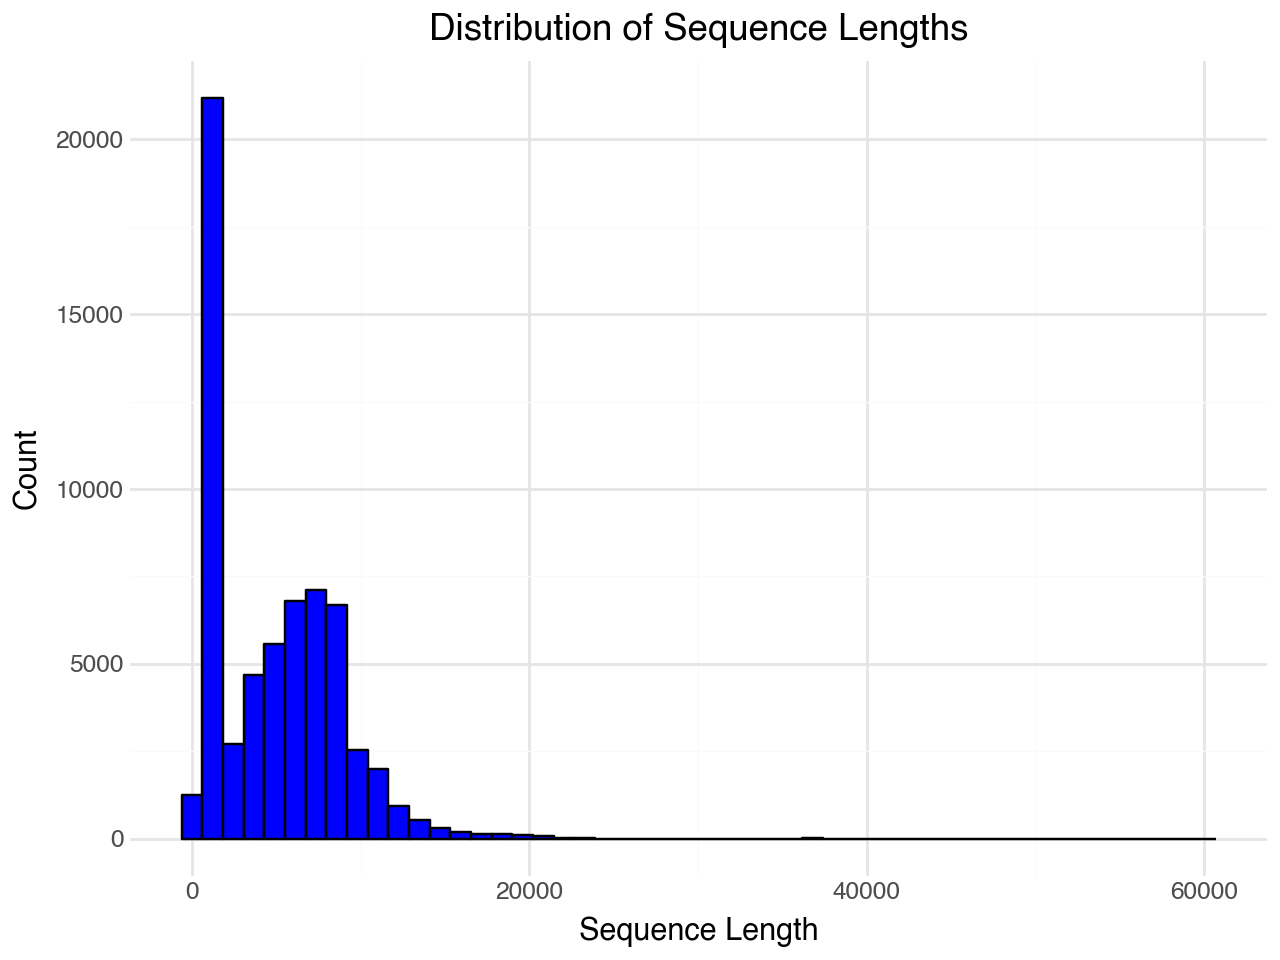

In [5]:
df = pd.DataFrame({"seq_len": [len(s) for s in train["sequence"]]})

print(df.describe())
(ggplot(df, aes(x="seq_len")) + 
    geom_histogram(bins=50, fill="blue", color="black") + 
    labs(title="Distribution of Sequence Lengths",
         x="Sequence Length",
         y="Count") + 
    theme_minimal())
